# Lab 1. 建立PM2.5監視系統
在這一個實驗中，我們要呼叫API，讓程式拿取目前的PM2.5的資料。然後再利用gropandas畫出台灣空汙地圖。

首先，我們先安裝必要的Library
## 安裝必要library
使用pip安裝套件在notebook裡下載必要libraries。這邊最主要的是geopandas，他是一個類似Pandas套件的，但是是專門適合用來處理地理資訊的。

In [ ]:
!pip install geopandas
!pip install descartes
!pip install pysal

In [ ]:
# OS相關的libraries
import zipfile, io

# 用來處理呼叫API的相關library
import urllib.request, requests
import json

# 科學運算相關的library
import pandas as pd
import numpy as np

# 視覺化套件的設計
import matplotlib.pyplot as plt
import geopandas as gp
from IPython.display import display
from pprint import pprint


## 取得PM2.5資料

透過opendata API下載當下之有檢測PM2.5各鄉鎮之資料。這裡我們使用urllib這個library取得資料並使用pandas製作成Dataframe供後續處理。

透過轉換成Dataframe的table格式，資料顯示搜集站台(Site)與縣市(County)。本lab將會把同縣市的PM2.5值平均後繪製成地圖。

In [ ]:
with urllib.request.urlopen("http://opendata.epa.gov.tw/ws/Data/ATM00625/?$format=json") as url:
    #data = json.loads(url.read().decode())
    pm25_df = pd.read_json(url.read())
    display(pm25_df.head())
    


,Site,county,PM25,DataCreationDate,ItemUnit
0,富貴角,新北市,24,2020-03-27 09:00,μg/m3
1,麥寮,雲林縣,21,2020-03-27 09:00,μg/m3
2,關山,臺東縣,12,2020-03-27 09:00,μg/m3
3,馬公,澎湖縣,6,2020-03-27 09:00,μg/m3
4,金門,金門縣,33,2020-03-27 09:00,μg/m3


## 使用 Geopandas

下面我們從政府的opendata處下載必要之圖資，此lab我們所使用的是台灣直轄市與縣市地圖。

In [ ]:
url = 'http://data.moi.gov.tw/MoiOD/System/DownloadFile.aspx?DATA=72874C55-884D-4CEA-B7D6-F60B0BE85AB0'


r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall()

先查看一下.shp檔案的名字！發現了COUNTY_MOI_1081121.shp。

In [ ]:
!ls

 COUNTY_MOI_1081121.dbf   Metadata.xml
 COUNTY_MOI_1081121.prj  '¡╫Ñ┐▓M│µ_1081113&21.xlsx'
 COUNTY_MOI_1081121.shp   sample_data
 COUNTY_MOI_1081121.shx   TW-01-301000100G-000017.xml


我們取出台灣鄉鎮市的shp圖資檔，解開後是一個Dataframe，讓我們看看前五個圖資的資訊。

In [ ]:
taiwan_shp = gp.read_file("COUNTY_MOI_1081121.shp", encoding = 'utf-8')

display(taiwan_shp.head())

,COUNTYID,COUNTYCODE,COUNTYNAME,COUNTYENG,geometry
0,Z,09007,連江縣,Lienchiang County,"MULTIPOLYGON (((119.96445 25.94552, 119.96427 ..."
1,G,10002,宜蘭縣,Yilan County,"MULTIPOLYGON (((121.95971 24.84494, 121.96064 ..."
2,N,10007,彰化縣,Changhua County,"POLYGON ((120.45655 24.20719, 120.48589 24.197..."
3,M,10008,南投縣,Nantou County,"POLYGON ((121.27086 24.23661, 121.27108 24.236..."
4,P,10009,雲林縣,Yunlin County,"MULTIPOLYGON (((120.08108 23.52412, 120.08161 ..."


由於我們的圖資單位是縣市等級，我們把PM2.5全省觀測站的資料，使用groupby把同一個縣市的PM2.5作平均歸入同一縣市。

In [ ]:
# 使用groupby 

final_df = pm25_df.groupby(['county'])['PM25'].mean()
taiwan_shp['PM25'] = taiwan_shp['COUNTYNAME'].map(final_df) # Powerful

display(taiwan_shp.head())

## 繪圖時間!

接下來我們就開始畫PM2.5的地圖吧。首先我們要設定python的繪圖library - Matplotlib。

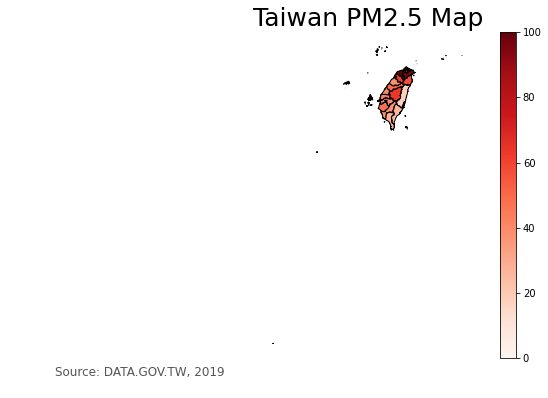

In [ ]:
vmin, vmax = 0, 100

# 調整繪圖的參數
fig, ax = plt.subplots(1, figsize=(10, 6))
ax.axis('off')
ax.set_title('Taiwan PM2.5 Map', fontdict={'fontsize': '25', 'fontweight' : '3'})
ax.annotate('Source: DATA.GOV.TW, 2019',xy=(0.1, .08),  xycoords='figure fraction',
            horizontalalignment='left', verticalalignment='top', fontsize=12, color='#555555')

sm = plt.cm.ScalarMappable(cmap='Reds', norm=plt.Normalize(vmin=vmin, vmax=vmax))

sm._A = []

cbar = fig.colorbar(sm)

taiwan_shp.plot(
    edgecolor='black',
    cmap=plt.cm.Reds, #指定顏色
    column='PM25', #指定從自身的這個 column 讀取顏色深度,
    #legend=True,
    ax=ax
)


plt.show()